# SSC prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import cmocean # Oceanography colour maps
#from sfoda.utils.myproj import MyProj

from inversion_sst_gp import (
    plot_helper,
    utils,
    gp_regression,
)

---

# Pre-processing functions

In [2]:
# Helper functions

def get_himawari_file_path_nasa_local(time_str):
    """Constructs the file path for a NOAA Himawari SST NetCDF file 
    that has been downloaded from NASA PODAAC"""
    time_id = pd.to_datetime(time_str).strftime("%Y%m%d%H%M%S")
    return f"{NON_PROCESSED_DIR}/{time_id}-{PRODUCT_NAME}.nc"

def get_himawari89_file_path_bom(time_str, sensor='H09'):
    """Constructs the file path for a BoM Himawari SST NetCDF file 
    from NCI's thredds server"""
    yyyy = pd.to_datetime(time_str).strftime("%Y")
    mm = pd.to_datetime(time_str).strftime("%m")
    dd = pd.to_datetime(time_str).strftime("%d")
    HH = pd.to_datetime(time_str).strftime("%H")
    
    timestr = '{}/{}/{}{}{}{}'.format(yyyy,mm,yyyy,mm,dd,HH)
    basepath = f'https://thredds.nci.org.au/thredds/dodsC/qm43/ghrsst/v02.0fv02/Continental/L3C-01hour/ABOM-L3C_GHRSST-SSTskin-AHI_{sensor}/'
    return '{}{}0000-ABOM-L3C_GHRSST-SSTskin-AHI_{}-1h-v02.0-fv02.0.nc'.format(basepath,timestr, sensor)
    
def load_and_preprocess_sst(file_path, target_time):
    """Loads SST data, selects time/region, flips latitude, and converts to Celsius."""
    with xr.open_dataset(file_path, decode_timedelta=False) as ds:
        ds_sel = ds.sel(
            #time=target_time,
            lon=slice(LON_LIMITS[0], LON_LIMITS[1]),
            lat=slice(LAT_LIMITS[1], LAT_LIMITS[0]),
        ).isel(time=0)

        lon = ds_sel.lon.values
        lat = ds_sel.lat.values
        sst = ds_sel.sea_surface_temperature.values

        lat = np.flip(lat)
        sst = np.flip(sst, axis=0)

        sst_celsius = sst - 273.15
    return lon, lat, sst_celsius


def get_sst_time_series_data(time_str, getfile=get_himawari89_file_path_bom, **kwargs):
    """Retrieves SST data for the current, previous, and next time steps."""
    current_time = np.datetime64(time_str)
    previous_time = current_time - np.timedelta64(TIME_STEP_SECONDS, "s")
    next_time = current_time + np.timedelta64(TIME_STEP_SECONDS, "s")

    file_curr = getfile(time_str, **kwargs)
    file_prev = getfile(str(previous_time), **kwargs)
    file_next = getfile(str(next_time), **kwargs)

    print(file_curr)

    lon, lat, T_curr = load_and_preprocess_sst(file_curr, current_time)
    _, _, T_prev = load_and_preprocess_sst(file_prev, previous_time)
    _, _, T_next = load_and_preprocess_sst(file_next, next_time)

    return lon, lat, T_curr, T_prev, T_next, current_time


# Main Processing Function
def process_himawari_sst_data(time_str, getfile=get_himawari89_file_path_bom, **kwargs):
    """Processes Himawari SST data and calculates temporal/spatial gradients."""
    print(f"  Starting processing for {time_str}")
    lon, lat, T_curr, T_prev, T_next, current_time = get_sst_time_series_data(time_str,\
                                                getfile=getfile, **kwargs)

    print(T_curr.shape)

    # Apply 3x3 window averaging to reduce resolution and noise
    lon_resampled = utils.calculate_mean_window_1d(lon, 3)
    lat_resampled = utils.calculate_mean_window_1d(lat, 3)
    T_curr_resampled = utils.calculate_mean_window_2d(T_curr, 3, 3, ignore_nan=IGNORE_NAN)
    T_prev_resampled = utils.calculate_mean_window_2d(T_prev, 3, 3, ignore_nan=IGNORE_NAN)
    T_next_resampled = utils.calculate_mean_window_2d(T_next, 3, 3, ignore_nan=IGNORE_NAN)

    # Calculate temporal derivative (dT/dt)
    dTdt = (T_next_resampled - T_prev_resampled) / (2 * TIME_STEP_SECONDS)

    # Calculate grid properties and spatial derivatives (dT/dx, dT/dy)
    lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(
        lon_resampled, lat_resampled
    )
    dTdx, dTdy = utils.finite_difference_2d(X, Y, T_curr_resampled)
    
    # Extend time dimension
    T_curr_resampled = T_curr_resampled[np.newaxis, :, :]
    dTdt = dTdt[np.newaxis, :, :]
    dTdx = dTdx[np.newaxis, :, :]
    dTdy = dTdy[np.newaxis, :, :]

    # Create an xarray Dataset to store all processed variables
    ds = xr.Dataset(
        coords={
            "lon": (["lon"], lon_resampled),
            "lat": (["lat"], lat_resampled),
            "LON": (["lat", "lon"], LON),
            "LAT": (["lat", "lon"], LAT),
            "X": (["lat", "lon"], X),
            "Y": (["lat", "lon"], Y),
            "lonc": lonc,
            "latc": latc,
            "time": (["time"], [current_time]),
            "time_step": TIME_STEP_SECONDS,
        },
        data_vars={
            "T": (["time","lat", "lon"], T_curr_resampled),
            "dTdt": (["time","lat", "lon"], dTdt),
            "dTdx": (["time","lat", "lon"], dTdx),
            "dTdy": (["time","lat", "lon"], dTdy),
        },
    )
    print(f"  Finished processing for {time_str}")
    return ds

---
# Tutorial starts here

In [3]:
# Rick's original  code
# Configuration
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (115, 118)
LAT_LIMITS = (-15.5, -12.5)  # Note: xarray sel uses [min, max], so flip for slicing
TIME_STEP_SECONDS = 3600  # Time step in seconds for derivative calculations
IGNORE_NAN = False  # Whether to ignore NaN values in calculations
time_str = "2023-09-22T04:00:00"

###
# Get the data
ds = process_himawari_sst_data(time_str, getfile=get_himawari89_file_path_bom, sensor='H09')
ds = ds.isel(time=0)

  Starting processing for 2023-09-22T04:00:00
https://thredds.nci.org.au/thredds/dodsC/qm43/ghrsst/v02.0fv02/Continental/L3C-01hour/ABOM-L3C_GHRSST-SSTskin-AHI_H09/2023/09/20230922040000-ABOM-L3C_GHRSST-SSTskin-AHI_H09-1h-v02.0-fv02.0.nc
(150, 150)
  Finished processing for 2023-09-22T04:00:00


In [4]:
# Compute gradients
time_step = ds.time_step.item()
lon, lat, To, dTdto = (ds[var].values for var in ("lon", "lat", "T", "dTdt"))
lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(lon, lat)
dTds1o, dTds2o = utils.finite_difference_2d(X, Y, To)

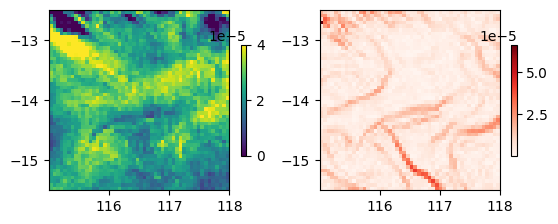

In [5]:
plt.figure()
ax=plt.subplot(121)
C=ax.pcolormesh(lon, lat, dTdto, cmap='viridis', vmin=0, vmax = 4e-5)
ax.set_aspect('equal')
plt.colorbar(C, shrink=0.3)

ax2=plt.subplot(122)
C=ax2.pcolormesh(lon, lat, np.abs(dTds1o+1j*dTds2o), cmap='Reds')
ax2.set_aspect('equal')
plt.colorbar(C, shrink=0.3)

# Using the de Kreij code to make a GP prediction

Adapted from this example:
https://github.com/rdkreij/inversion-sst-gp/blob/main/4_satellite_application/4_1_case_1_rossby_number.py

Calculating GP regression prediction


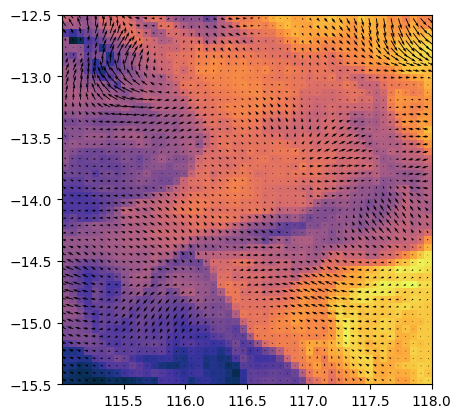

In [6]:
guess_params = {
    "sigma_u": 9e-2,
    "l_u": 3e4,
    "tau_u": 1e-2,
    "sigma_v": 9e-2,
    "l_v": 3e4,
    "tau_v": 1e-2,
    "sigma_S": 3e-7,
    "l_S": 2e4,
    "tau_S": 2e-7,
    "sigma_tau": 1e-2,
}

print("Calculating GP regression prediction")
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_regression.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, guess_params, X, Y, time_step)
)

# Plot the mean estimation
plt.figure()
ax=plt.subplot(111)
plt.pcolormesh(lon, lat, To, cmap='cmo.thermal')

plt.quiver(LON, LAT, muustar, muvstar, ) # scale_units='xy', scale=2e-5
ax.set_aspect('equal')

---
# Run the parameter optimization

In [7]:
# Set model hyperparameters
initial_params = {
    "sigma_u": 9e-2,
    "l_u": 3e4,
    "tau_u": 1e-2,
    "sigma_S": 3e-7,
    "l_S": 2e4,
    "tau_S": 2e-7,
    "sigma_tau": 1e-2,
}
penalty_params = {
    "l_u": [3e4, 0.5e4],
    "sigma_u": [9e-2, 2e-2],
    "tau_u": [1e-2, 0.1e-2],
    "l_S": [2e4, 2e4],
    "sigma_S": [3e-7, 5e-6],
    "tau_S": [2e-7, 5e-6],
}
bounds_params = {
    "sigma_u": [1e-10, 10],
    "l_u": [1, 1e6],
    "tau_u": [1e-10, 1],
    "sigma_S": [1e-8, 1e-3],
    "l_S": [1, 1e6],
    "tau_S": [1e-15, 1e-3],
    "sigma_tau": [1e-15, 1],
}
prop_sat = {
    "initial_params": initial_params,
    "const_params": {},
    "penalty_params": penalty_params,
    "share_len": True,
    "share_tau": True,
    "share_sigma": True,
    "solve_log": True,
    "bounds_params": bounds_params,
}

# Metric functions
def run_gprm_optim(time_str, dTds1, dTds2, dTdt, X, Y, tstep, prop, callback="on"):
    mask = np.ones_like(X, dtype=bool)
    gprm = gp_regression.GPRegressionJoint(dTds1, dTds2, dTdt, tstep, X, Y, mask)
    est_params = gprm.estimate_params(**prop, callback=callback)
    return {
        "step": time_str,
        "est_params": est_params,
    }

# Run model
print("Running GP optimization")
tstep = time_step
results = run_gprm_optim(
    time_str, dTds1o, dTds2o, dTdto, X, Y, tstep, prop_sat
)

results

Running GP optimization
sigma_u       l_u           tau_u         sigma_S       l_S           tau_S         sigma_tau     lml        
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          1.6379e+04 
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          1.6379e+04 


KeyboardInterrupt: 

In [ ]:
print("Calculating GP regression prediction")
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_regression.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, results['est_params'], X, Y, time_step)
)

plt.figure()
ax=plt.subplot(111)
plt.pcolormesh(lon, lat, To, cmap='cmo.thermal')

plt.quiver(LON, LAT, muustar, muvstar, ) # scale_units='xy', scale=2e-5
ax.set_aspect('equal')

---
# (Testing) Grab NASA earthdata product straight from the server

In [ ]:
#!pip install earthaccess
import earthaccess

earthaccess.login()

In [ ]:
results = earthaccess.search_data(
    short_name="H09-AHI-L3C-ACSPO-v2.90",
    bounding_box=(115, -15.5, 118, -12.5),
    temporal=("2023-09-22T03:00:00", "2023-09-22T06:00:00"),
)
results

In [ ]:
# this returns a file handle that xarray can use
f=earthaccess.open(results) 
f

In [ ]:
load_and_preprocess_sst(f[0], None)

---

# (Testing) Use the BoM Himawari data

Attempt at doing different filtering, gradient computation. Not working.

In [ ]:


time1 ='20230706'
time2 ='20230707'
year = 2023
area = [113, -23, 114.1, -21.5] # Ningaloo
region = 'ningaloo'



time_str = "2023-09-22T04:00:00"
# time_str = "2023-09-22T05:00:00"

area = [115, -15.5, 118, -12.5] # Ningaloo
region = 'dekreij_paper'


# Get himawari data
####

TIME_STEP_SECONDS = 3600
x1,x2=area[0], area[2]
y1,y2=area[1], area[3]
current_time = np.datetime64(time_str)
previous_time = current_time - np.timedelta64(TIME_STEP_SECONDS, "s")
next_time = current_time + np.timedelta64(TIME_STEP_SECONDS, "s")

f1 = get_himawari89_file_path_bom(str(previous_time))
f2 = get_himawari89_file_path_bom(str(current_time))
f3 = get_himawari89_file_path_bom(str(next_time))

sst1 = xr.open_dataset(f1)\
    .sel(lon=slice(x1,x2), lat=slice(y2,y1))
sst2 = xr.open_dataset(f2)\
    .sel(lon=slice(x1,x2), lat=slice(y2,y1))
sst3 = xr.open_dataset(f3)\
    .sel(lon=slice(x1,x2), lat=slice(y2,y1))

sstraw = xr.concat([sst1,sst2,sst3], dim='time')['sea_surface_temperature']
sstraw

sstraw.isel(time=0).plot()

In [ ]:
from scipy.signal import convolve2d


# Apply convolution across spatial dimensions
def apply_convolution(da, kernel):
    convolved = []
    for t in da.time:
        slice_2d = da.sel(time=t)
        result = convolve2d(slice_2d, kernel, mode='same', boundary='symm' )
        convolved.append(result)
    return xr.DataArray(
        np.array(convolved),
        coords=da.coords,
        dims=da.dims
    )

###
ss = 3
dt = TIME_STEP_SECONDS
dx = 2000.
utmzone = 50

kernel = np.ones((ss, ss)) / ss**2

sst = apply_convolution(sstraw, kernel).isel(lat=slice(None,None,ss), lon=slice(None,None,ss))
sst.isel(time=0).plot()

In [ ]:
# Compute the temporal gradients

# Backward difference
dTdt = sst.isel(time=1) - sst.isel(time=0)
dTdt /= dt

# Central
# dTdt = sst.isel(time=2) - sst.isel(time=0)
# dTdt /= 2*dt

# Spatial gradient at time step = ?
dTdx = dTdx_.isel(time=0)
dTdy = dTdy_.isel(time=0)

###

idx = np.isnan(dTdt.values) | np.isnan(dTdx) | np.isnan(dTdy)

lon, lat = np.meshgrid(sst['lon'], sst['lat'])
P = MyProj(None, utmzone=utmzone, isnorth=False)
Xm, Ym = P.to_xy(lon, lat)

plt.figure()
ax=plt.subplot(121)
dTdt.plot(ax=ax, cmap='viridis', vmin=0, vmax = 4e-5)
ax.set_aspect('equal')

ax2=plt.subplot(122)
(np.abs(dTdx+1j*dTdy)).plot(ax=ax2, cmap='Reds')
ax2.set_aspect('equal')

In [ ]:
# Compute spatial gradients
kernel_dx = np.array([[1, 0, -1]]) / 2 / (ss*dx)
kernel_dy = np.array([[1, 0, -1]]) / 2 / (ss*dx)

dTdx_ = apply_convolution(sst, kernel_dx)
dTdy_ = apply_convolution(sst, kernel_dy)

dTdy_.isel(time=0).plot()